Resultados para a classe 0:
Acurácia: 0.7998
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.82      0.90      0.86       861
           1       0.73      0.59      0.65       403

    accuracy                           0.80      1264
   macro avg       0.78      0.74      0.76      1264
weighted avg       0.79      0.80      0.79      1264



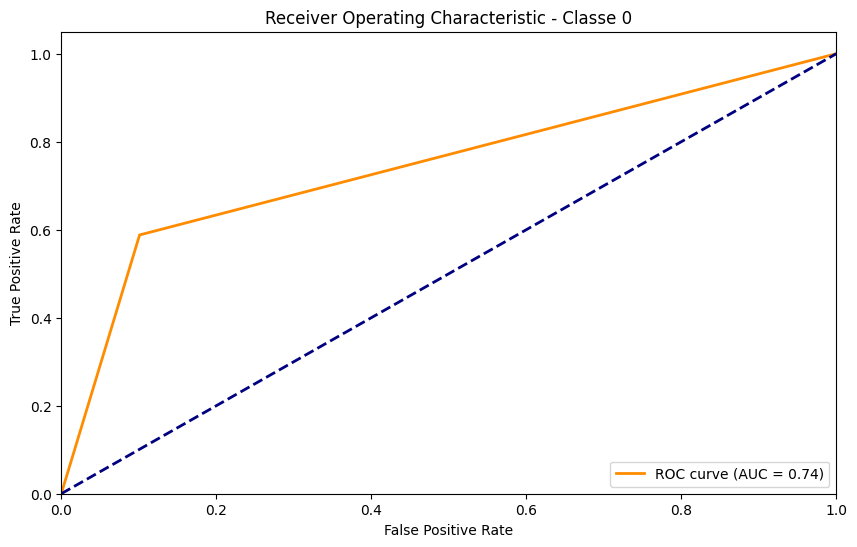

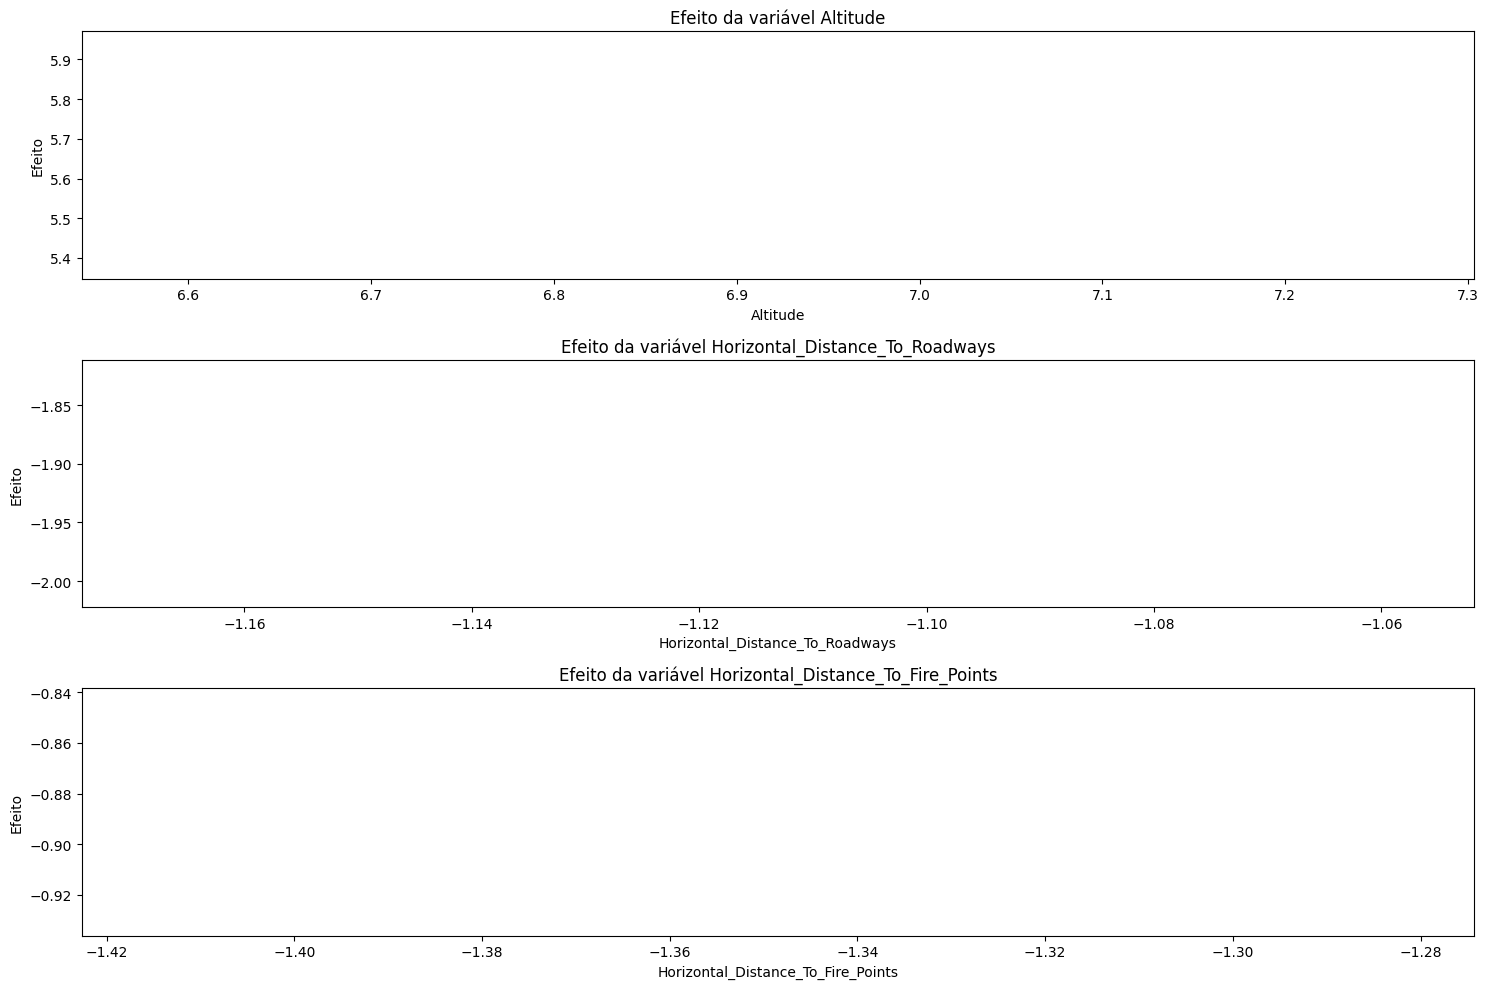

Resultados para a classe 1:
Acurácia: 0.8465
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.91      0.80      0.85       695
           1       0.79      0.90      0.84       569

    accuracy                           0.85      1264
   macro avg       0.85      0.85      0.85      1264
weighted avg       0.85      0.85      0.85      1264



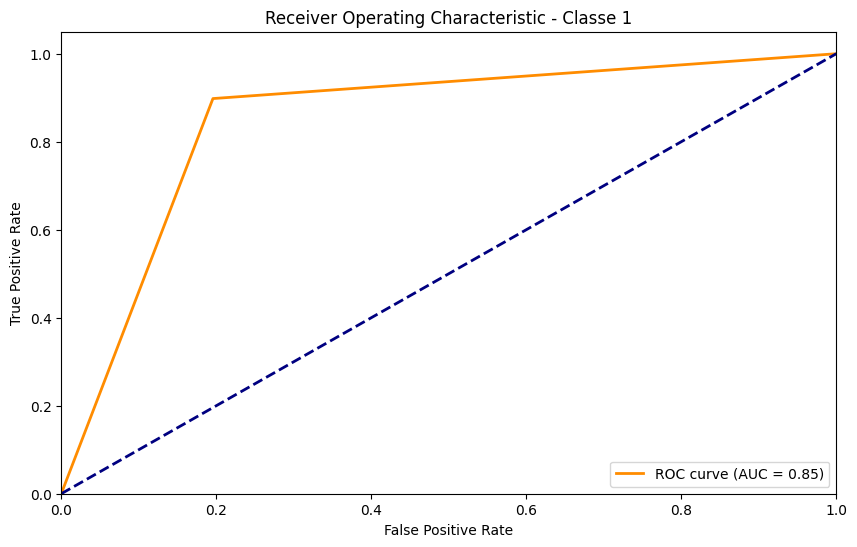

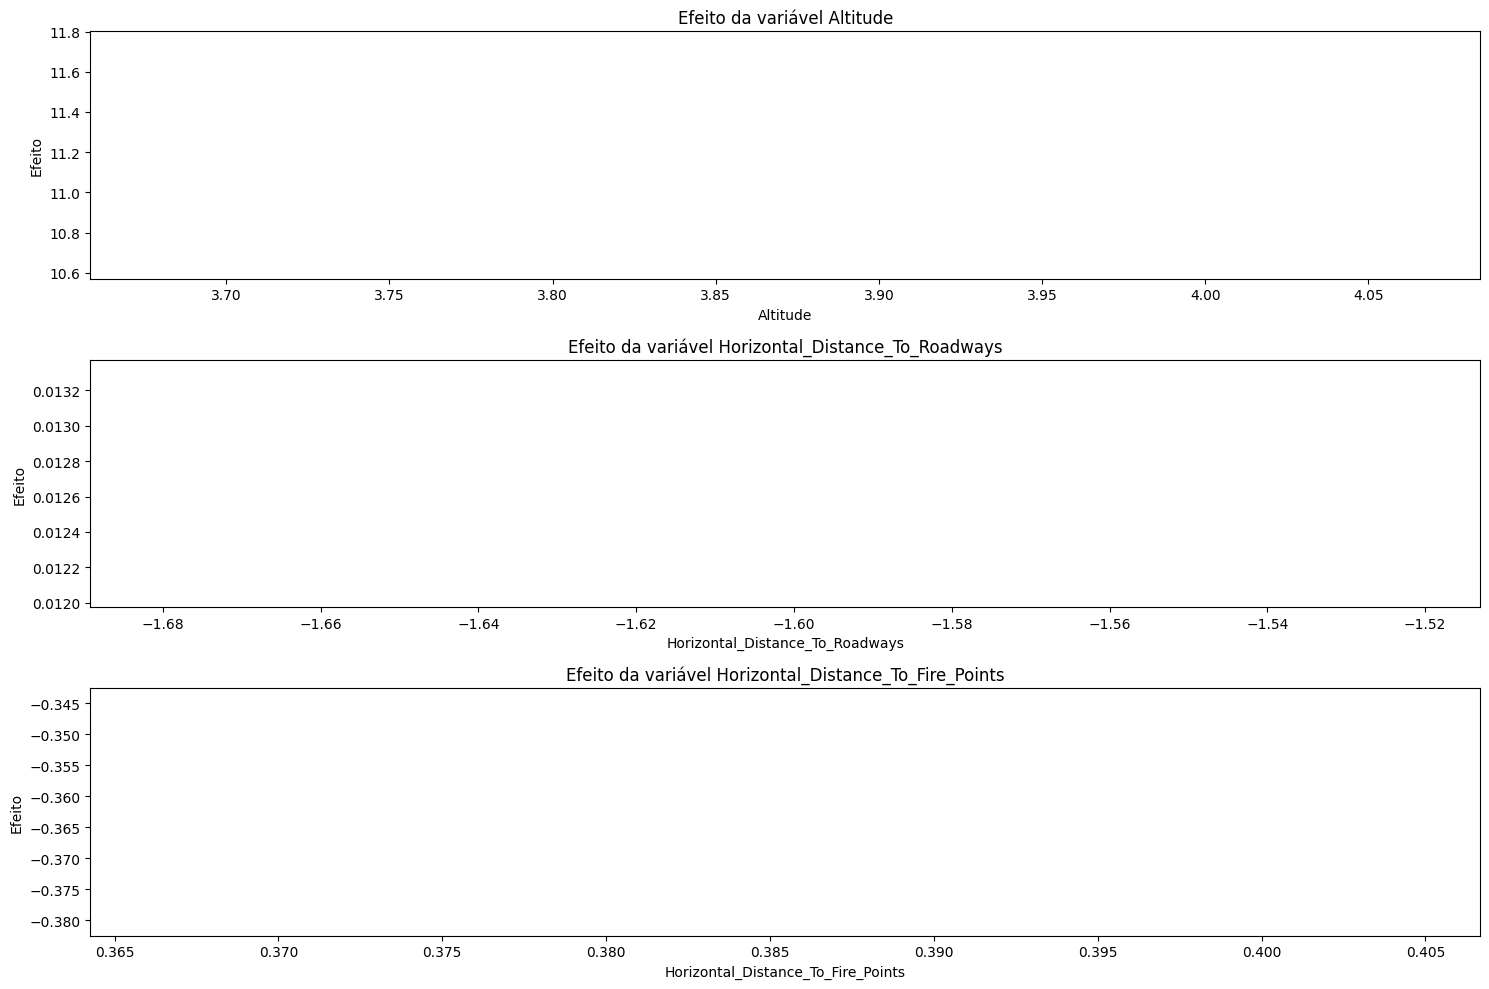

Resultados para a classe 2:
Acurácia: 0.9747
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       972
           1       0.94      0.95      0.95       292

    accuracy                           0.97      1264
   macro avg       0.96      0.97      0.96      1264
weighted avg       0.97      0.97      0.97      1264



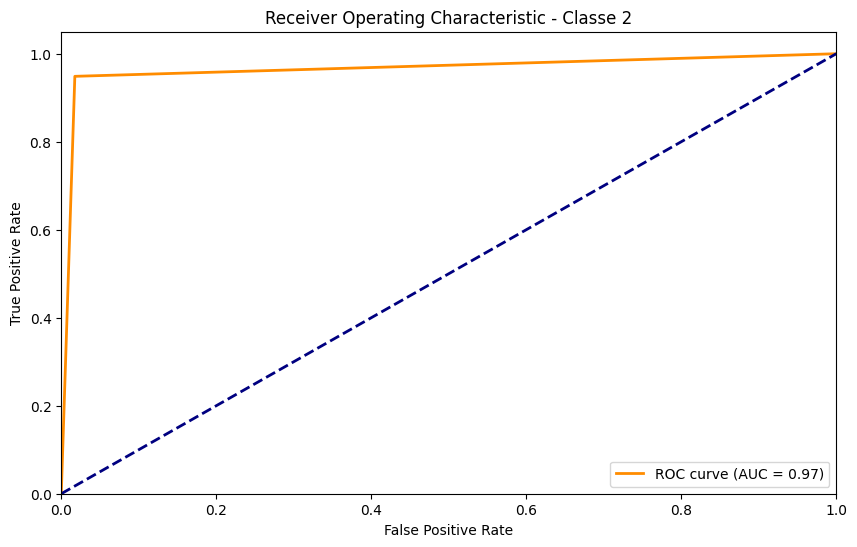

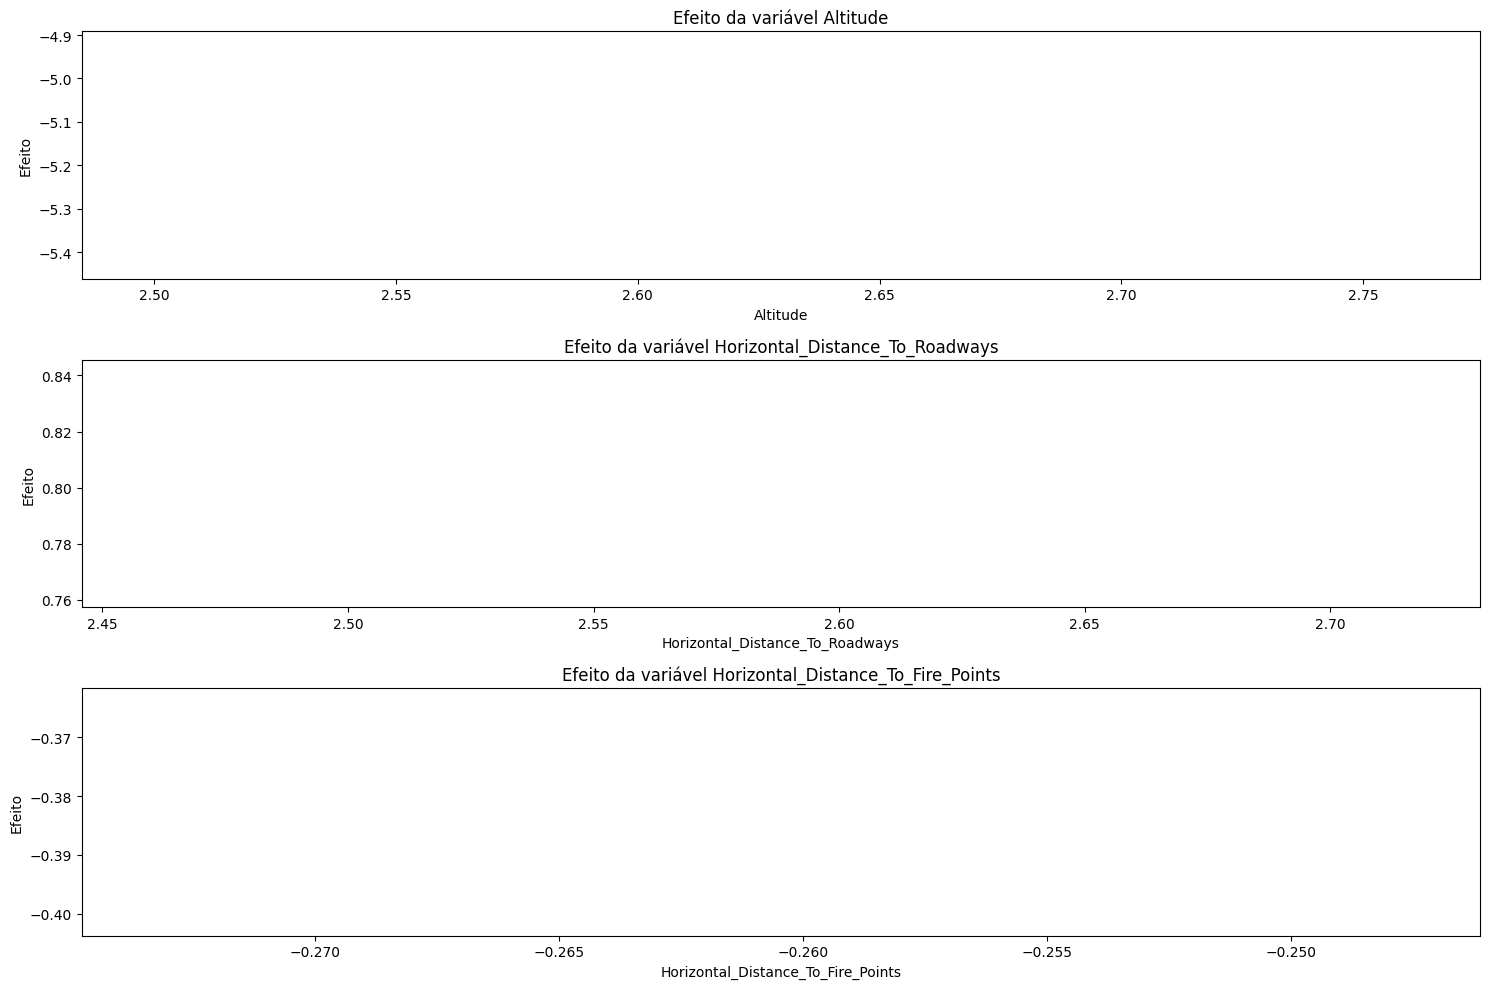

C:\Users\rodri\AppData\Local\Temp\ipykernel_16592\1117922418.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[0, 1, 2], y=accuracies, palette="viridis")


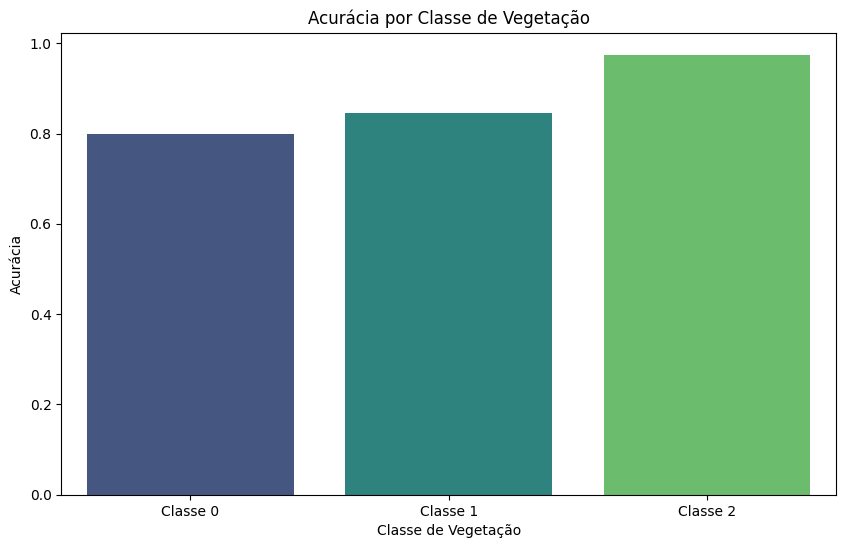

Acurácia com cross-validation para a classe 0: 0.6605
Acurácia com cross-validation para a classe 1: 0.5336
Acurácia com cross-validation para a classe 2: 0.8060


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
from pygam import LogisticGAM, s
import DataClass as dc

# Load the data
dt2 = pd.read_csv(dc.CSV_PATH_2)
dt5 = pd.read_csv(dc.CSV_PATH_5)
dt7 = pd.read_csv(dc.CSV_PATH_7)

data = pd.concat([dt2, dt5, dt7], ignore_index=True)

# Convert VEGETATION_TYPE to numerical values
label_encoder = LabelEncoder()
data[dc.VEGETATION_TYPE] = label_encoder.fit_transform(data[dc.VEGETATION_TYPE])

# Feature Selection
X = data[[dc.ALTITUDE, dc.HORIZONTAL_DISTANCE_TO_ROADWAYS, dc.HORIZONTAL_DISTANCE_TO_FIRE_POINTS]]
Y = data[dc.VEGETATION_TYPE]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=5)

# Evaluate the model for each class (binary classification) and generate plots
accuracies = []
for class_label in [0, 1, 2]:  # For each Vegetation_Type class
    # Transform the dependent variable into binary (class_label vs the rest)
    y_train_binary = (y_train == class_label).astype(int)
    y_test_binary = (y_test == class_label).astype(int)
    
    # Create and train the GAM model with B-splines
    model = LogisticGAM(s(0, n_splines=10, spline_order=3) + 
                        s(1, n_splines=10, spline_order=3) + 
                        s(2, n_splines=10, spline_order=3))
    
    model.fit(X_train, y_train_binary)
    
    # Predict on the test set
    predictions = model.predict(X_test)
    
    # Evaluate the model with the metrics
    accuracy = accuracy_score(y_test_binary, predictions)
    report = classification_report(y_test_binary, predictions)
    accuracies.append(accuracy)
    
    print(f"Results for class {class_label}:")
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(report)
    
    # Generate the ROC curve
    y_prob = model.predict(X_test)
    fpr, tpr, thresholds = roc_curve(y_test_binary, y_prob)
    roc_auc = auc(fpr, tpr)
    
    # ROC Curve
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - Class {class_label}')
    plt.legend(loc="lower right")
    plt.show()
    
    # Plotting feature importance
    feature_names = X.columns  # Feature names
    n_features = X.shape[1]  # Number of features
    
    plt.figure(figsize=(15, 10))
    
    # Plotting the effects for each feature, ignoring the intercept
    for i in range(n_features):
        # Check if the term is not the intercept and if the index is within range
        if i >= len(model.terms) or model.terms[i].isintercept:
            continue
        
        plt.subplot(n_features, 1, i+1)  # Subplot for each feature
        plt.title(f'Effect of feature {feature_names[i]}')
        
        # Generate the partial dependence for feature i
        pdp = model.partial_dependence(i, X=X)  # Use X to generate the partial dependence
        plt.plot(pdp[0], pdp[1], label=f'Effect {feature_names[i]}')  # Plotting the partial dependence results
        
        plt.xlabel(feature_names[i])
        plt.ylabel('Effect')
    
    plt.tight_layout()
    plt.show()

# Plot accuracy by class
plt.figure(figsize=(10, 6))
sns.barplot(x=[0, 1, 2], y=accuracies, palette="viridis")
plt.xlabel('Vegetation Class')
plt.ylabel('Accuracy')
plt.title('Accuracy by Vegetation Class')
plt.xticks([0, 1, 2], ['Class 0', 'Class 1', 'Class 2'])
plt.show()

# Evaluate the model with cross-validation for each class
accuracies_cv = []
for class_label in [0, 1, 2]:
    # Transform the dependent variable into binary
    y_train_binary = (y_train == class_label).astype(int)
    
    # Create and train the GAM model with B-splines
    model = LogisticGAM(s(0, n_splines=10, spline_order=3) + 
                        s(1, n_splines=10, spline_order=3) + 
                        s(2, n_splines=10, spline_order=3))  
    
    # Perform cross-validation and calculate the mean accuracy
    accuracies = cross_val_score(model, X_train, y_train_binary, cv=5, scoring='accuracy')
    accuracies_cv.append(accuracies.mean())
    print(f"Cross-validation accuracy for class {class_label}: {accuracies.mean():.4f}")